# Shooting Method

In [1]:
import numpy as np
from scipy import integrate, optimize
from matplotlib import pyplot as plt

import scienceplots
plt.style.use(['science','ieee'])
plt.rcParams["figure.figsize"] = (10, 6)

# Natural units
hbar = m = 1

In [2]:
def euler(ypp, xi, xf, yi, ypi, n=1000, args=None):
    x, dx = np.linspace(xi, xf, n, retstep=True)

    yp = np.empty(n)
    y = np.empty(n)

    yp[0] = ypi
    y[0] = yi

    for i in range(1, n):
        yp[i] = yp[i-1] + dx * ypp(x[i], y[i-1], yp[i-1], *args)
        y[i] = y[i-1] + dx * yp[i-1]

    return x, y

## Boundary-value problems

In [3]:
def solve_bvp(ypp, xi, xf, yi, yf, ypi_i, ypi_f, ypi_h, args=None):
    ypi = np.arange(ypi_i, ypi_f, ypi_h)
    Y_f = np.empty(ypi.size)
    
    for i in range(ypi.size):
        x, y = euler(ypp, xi, xf, yi, ypi[i], args=args)
        Y_f[i] = y[-1]

        if i and (Y_f[i] - yf) * (Y_f[i-1] - yf) < 0:
            return x, ypi[i], y

### Legrende Differential Equation

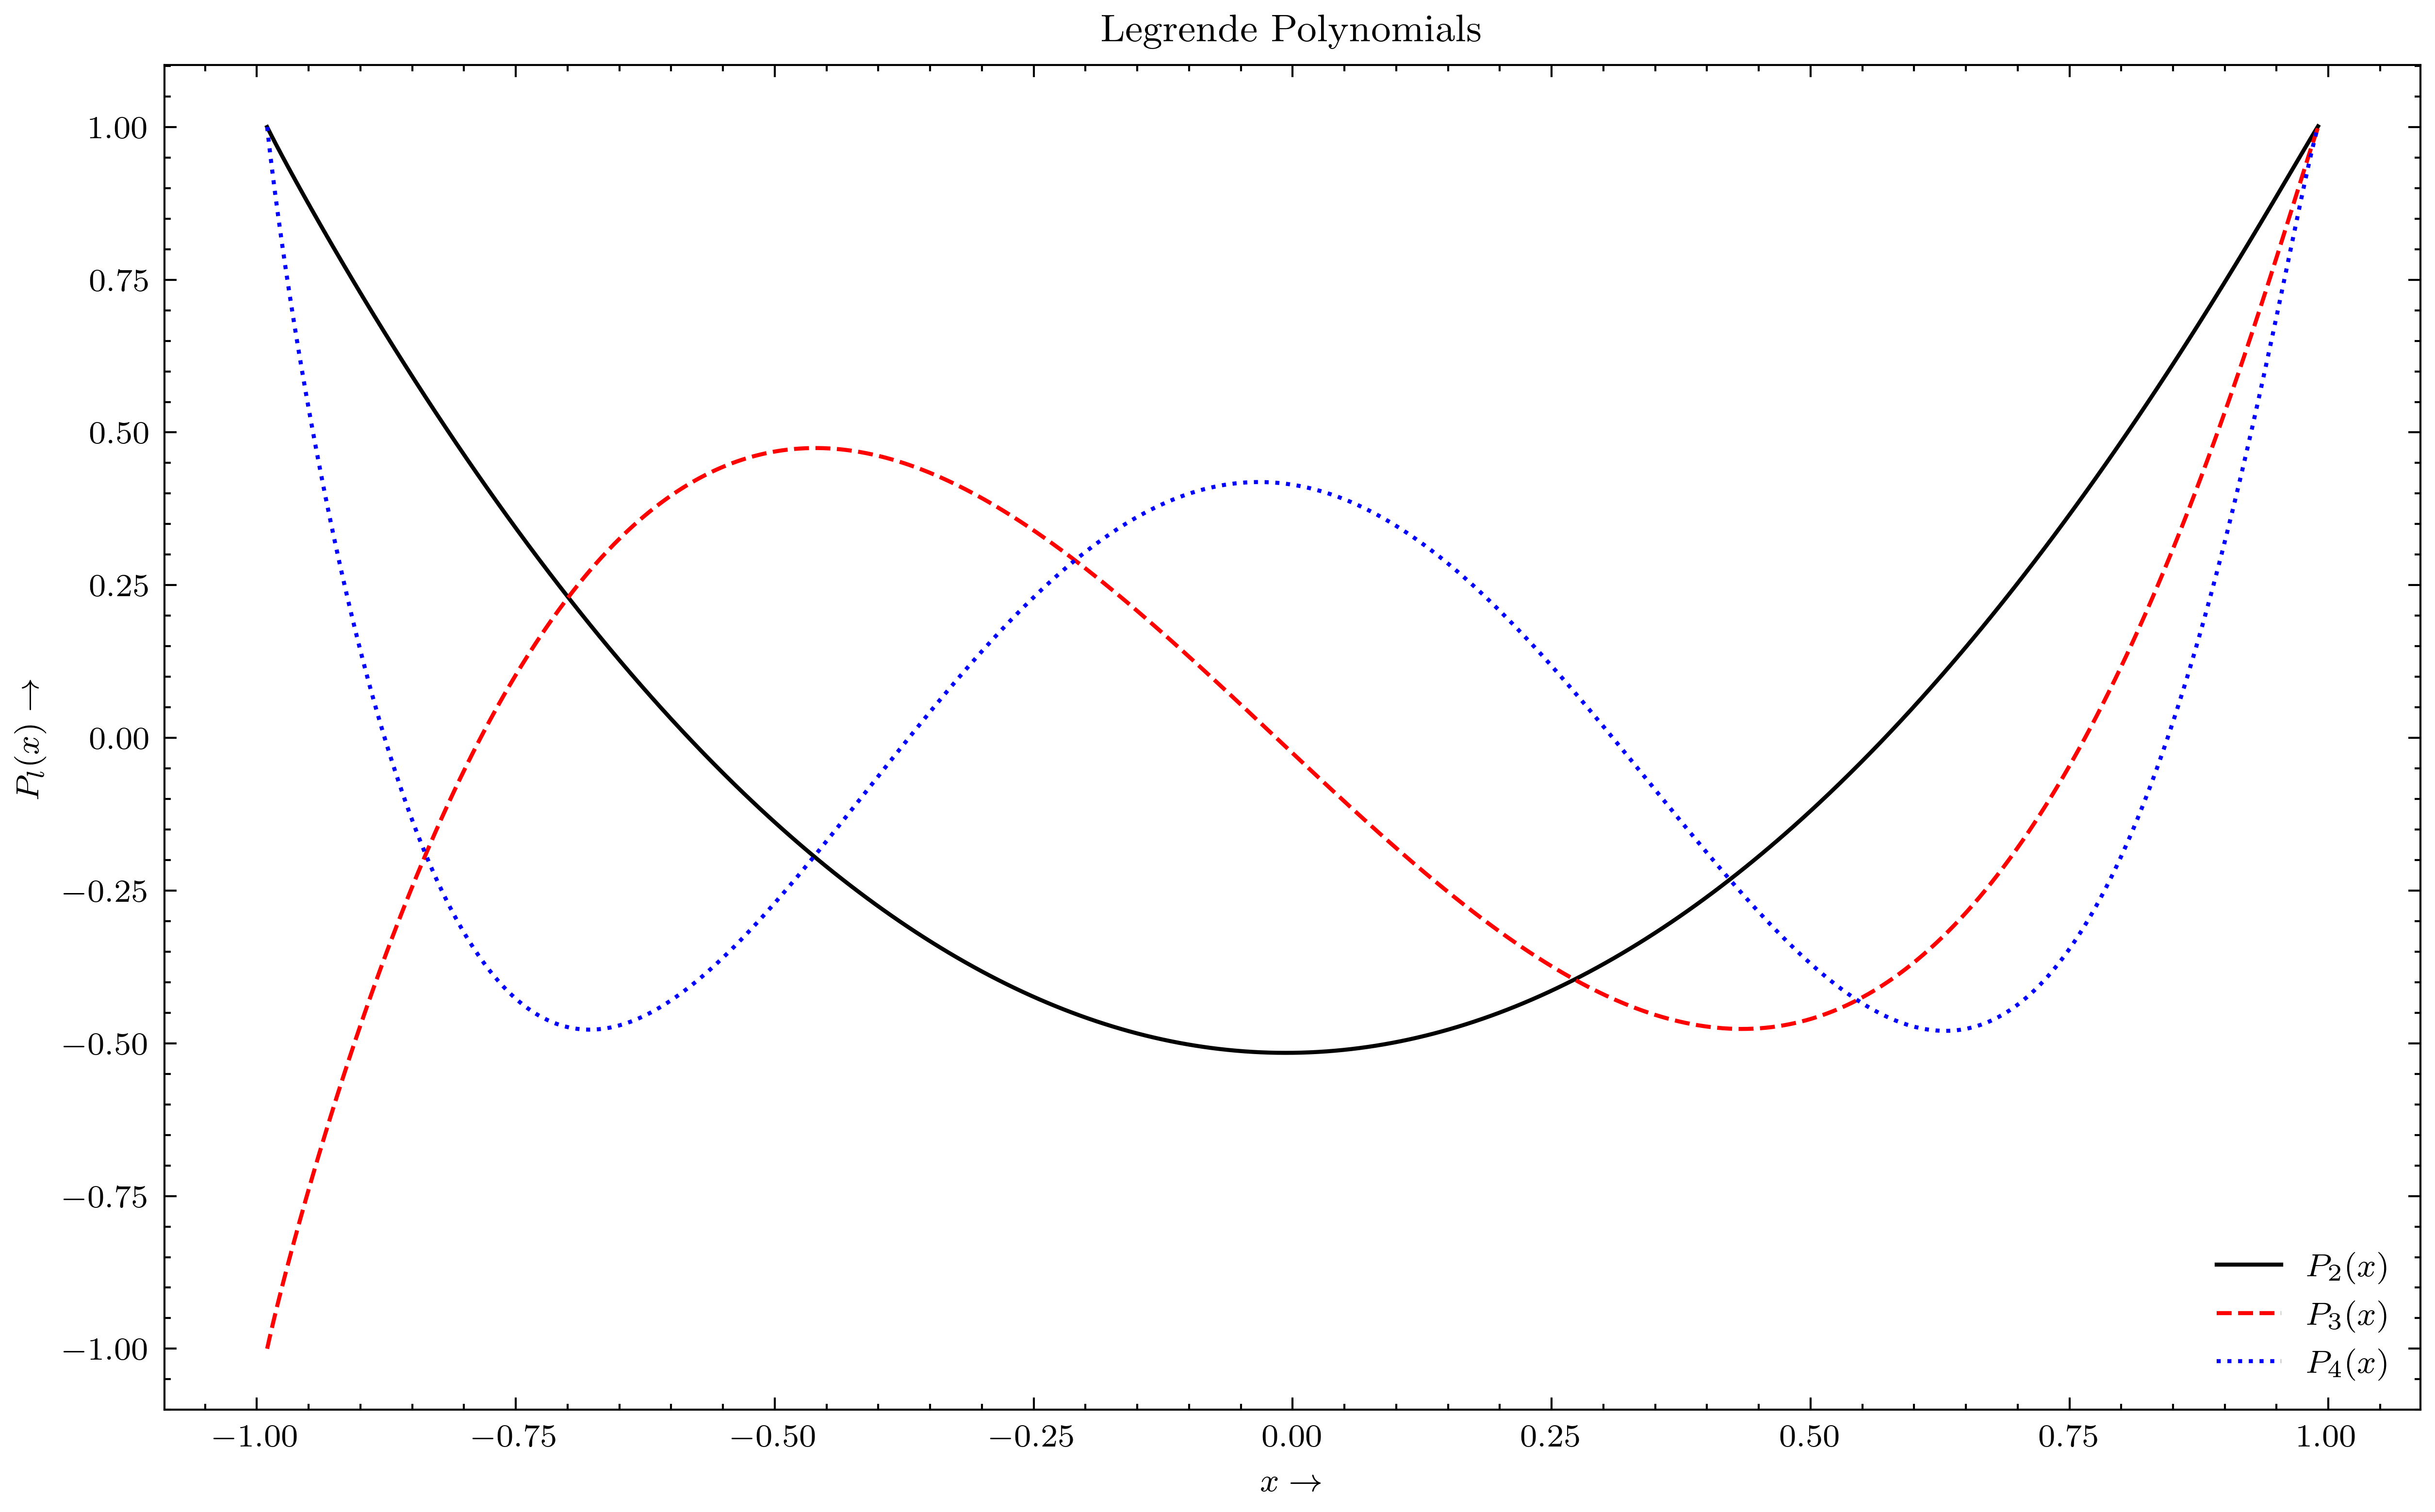

In [4]:
def ypp(x, y, yp, l):
    return (2 * x * yp - l * (l + 1) * y) / (1 - x**2)

ypi_i, ypi_f, ypi_h = -20, 20, 0.1

l =  2, 3, 4
xi = - 0.99
xf = 0.99
yi = 1, -1, 1
yf = 1, 1, 1

for k in range(len(l)):
    x, ypi, y = solve_bvp(ypp, xi, xf, yi[k], yf[k], ypi_i, ypi_f, ypi_h, args=(l[k],))
    plt.plot(x, y, label=f"$P_{l[k]}(x)$")

plt.title("Legrende Polynomials")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$P_l(x) \\rightarrow$")
plt.legend()
plt.show()

### Hermite Differential Equation

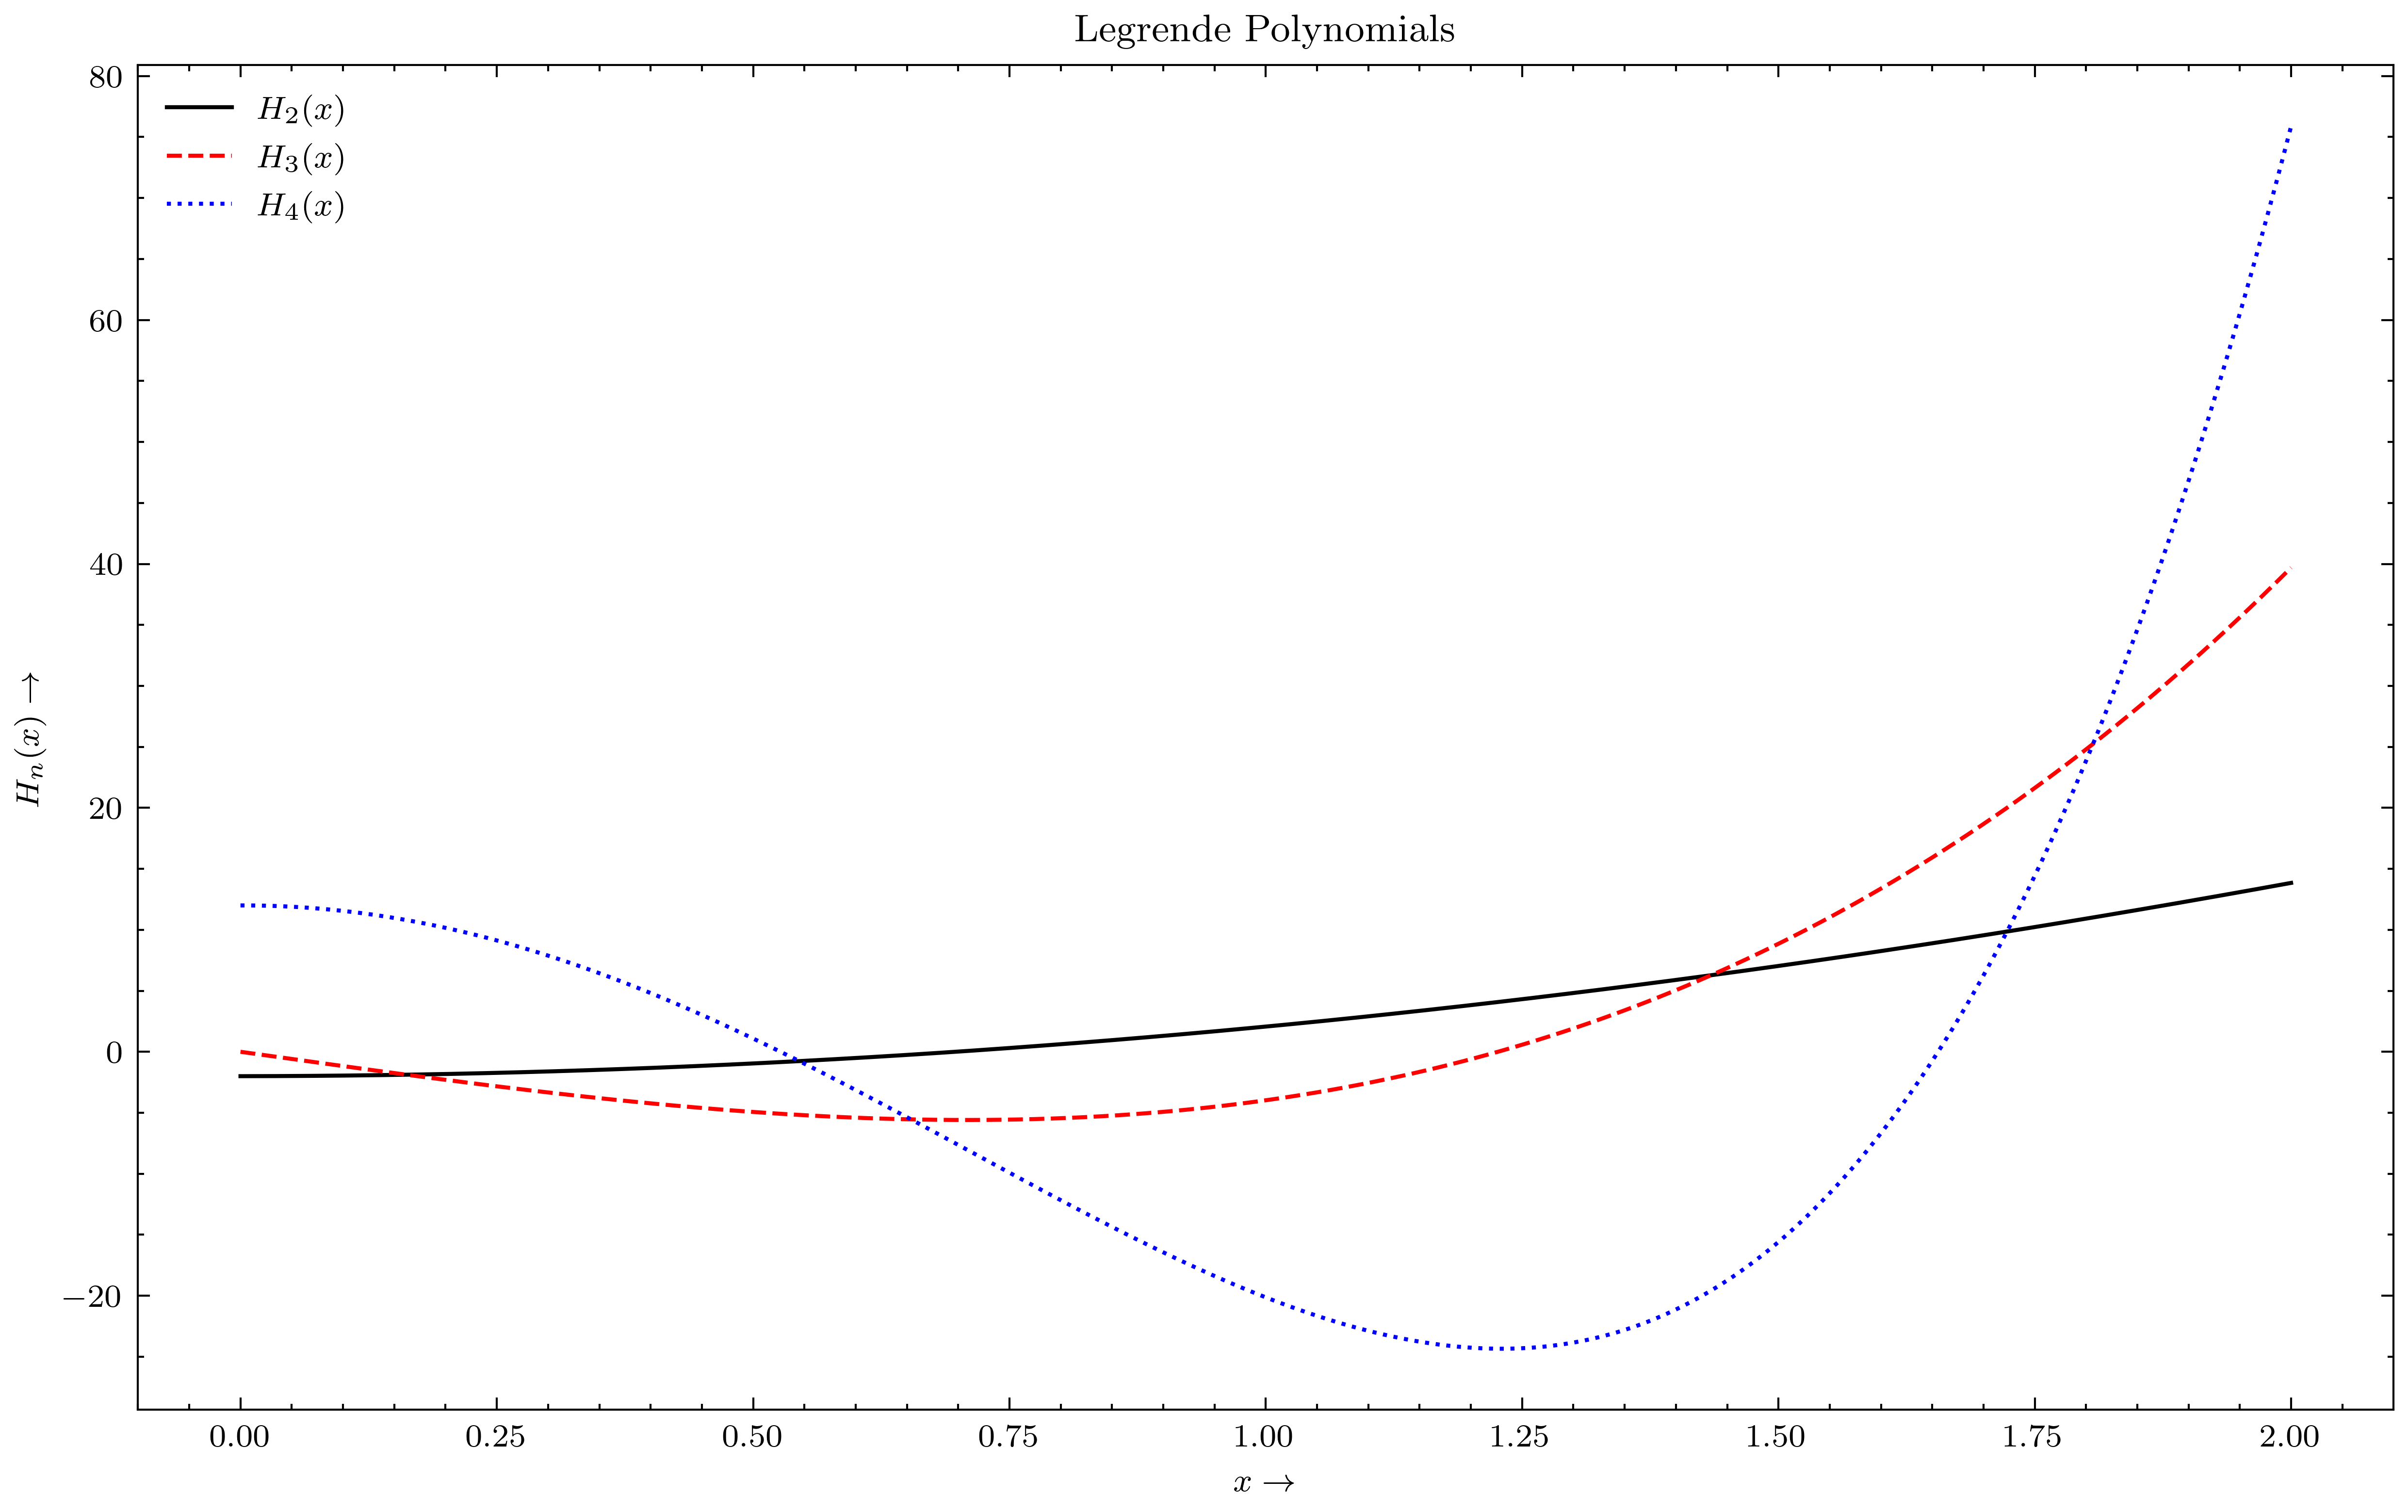

In [5]:
def ypp(x, y, yp, n):
    return 2 * x * yp - 2 * n * y

ypi_i, ypi_f, ypi_h = -20, 20, 0.1

n =  2, 3, 4
xi = 0
xf = 2
yi = -2, 0, 12
yf = 14, 40, 76

for k in range(len(n)):
    x, ypi, y = solve_bvp(ypp, xi, xf, yi[k], yf[k], ypi_i, ypi_f, ypi_h, args=(n[k],))
    plt.plot(x, y, label=f"$H_{n[k]}(x)$")

plt.title("Legrende Polynomials")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$H_n(x) \\rightarrow$")
plt.legend()
plt.show()

## Eigenvalue Problems

In [12]:
plt.rcParams["figure.figsize"] = (10, 15)

def solve_eig_eqn(ypp, xi, xf, yi, yf, Ei, Ef, Eh, ypi=1):
    E = np.arange(Ei, Ef, Eh)
    Y_f = np.empty(E.size)
    x = []
    eigen_values = []
    eigen_vectors = []
    
    for i in range(E.size):
        x, y = euler(ypp, xi, xf, yi, ypi, args=(E[i],))
        Y_f[i] = y[-1]

        if i and (Y_f[i] - yf) * (Y_f[i-1] - yf) < 0:
            eigen_values.append(E[i])
            eigen_vectors.append(y.copy())

    return x, np.array(eigen_values), np.array(eigen_vectors)
    

In [13]:
def sch_eqn(V):
    def ypp(x, y, yp, E):
        return - (2 * m / hbar**2) * (E - V(x)) * y
    return ypp

### Infinite square potential well

$$V(x)
=
\begin{cases}
0, & -a < x < a\\
\lim\limits_{V_0 \to \infty} V_0, & \text{otherwise}
\end{cases}
$$

In [14]:
a = 1
V_0 = 1e6

@np.vectorize
def V(x):
    if -a < x < a:
        return 0
    else:
        return V_0

xi, xf, yi, yf= -1, 1, 0, 0
Ei, Ef, Eh = 0, 12, 0.01

x, E, psi = solve_eig_eqn(sch_eqn(V), xi, xf, yi, yf, Ei, Ef, Eh)

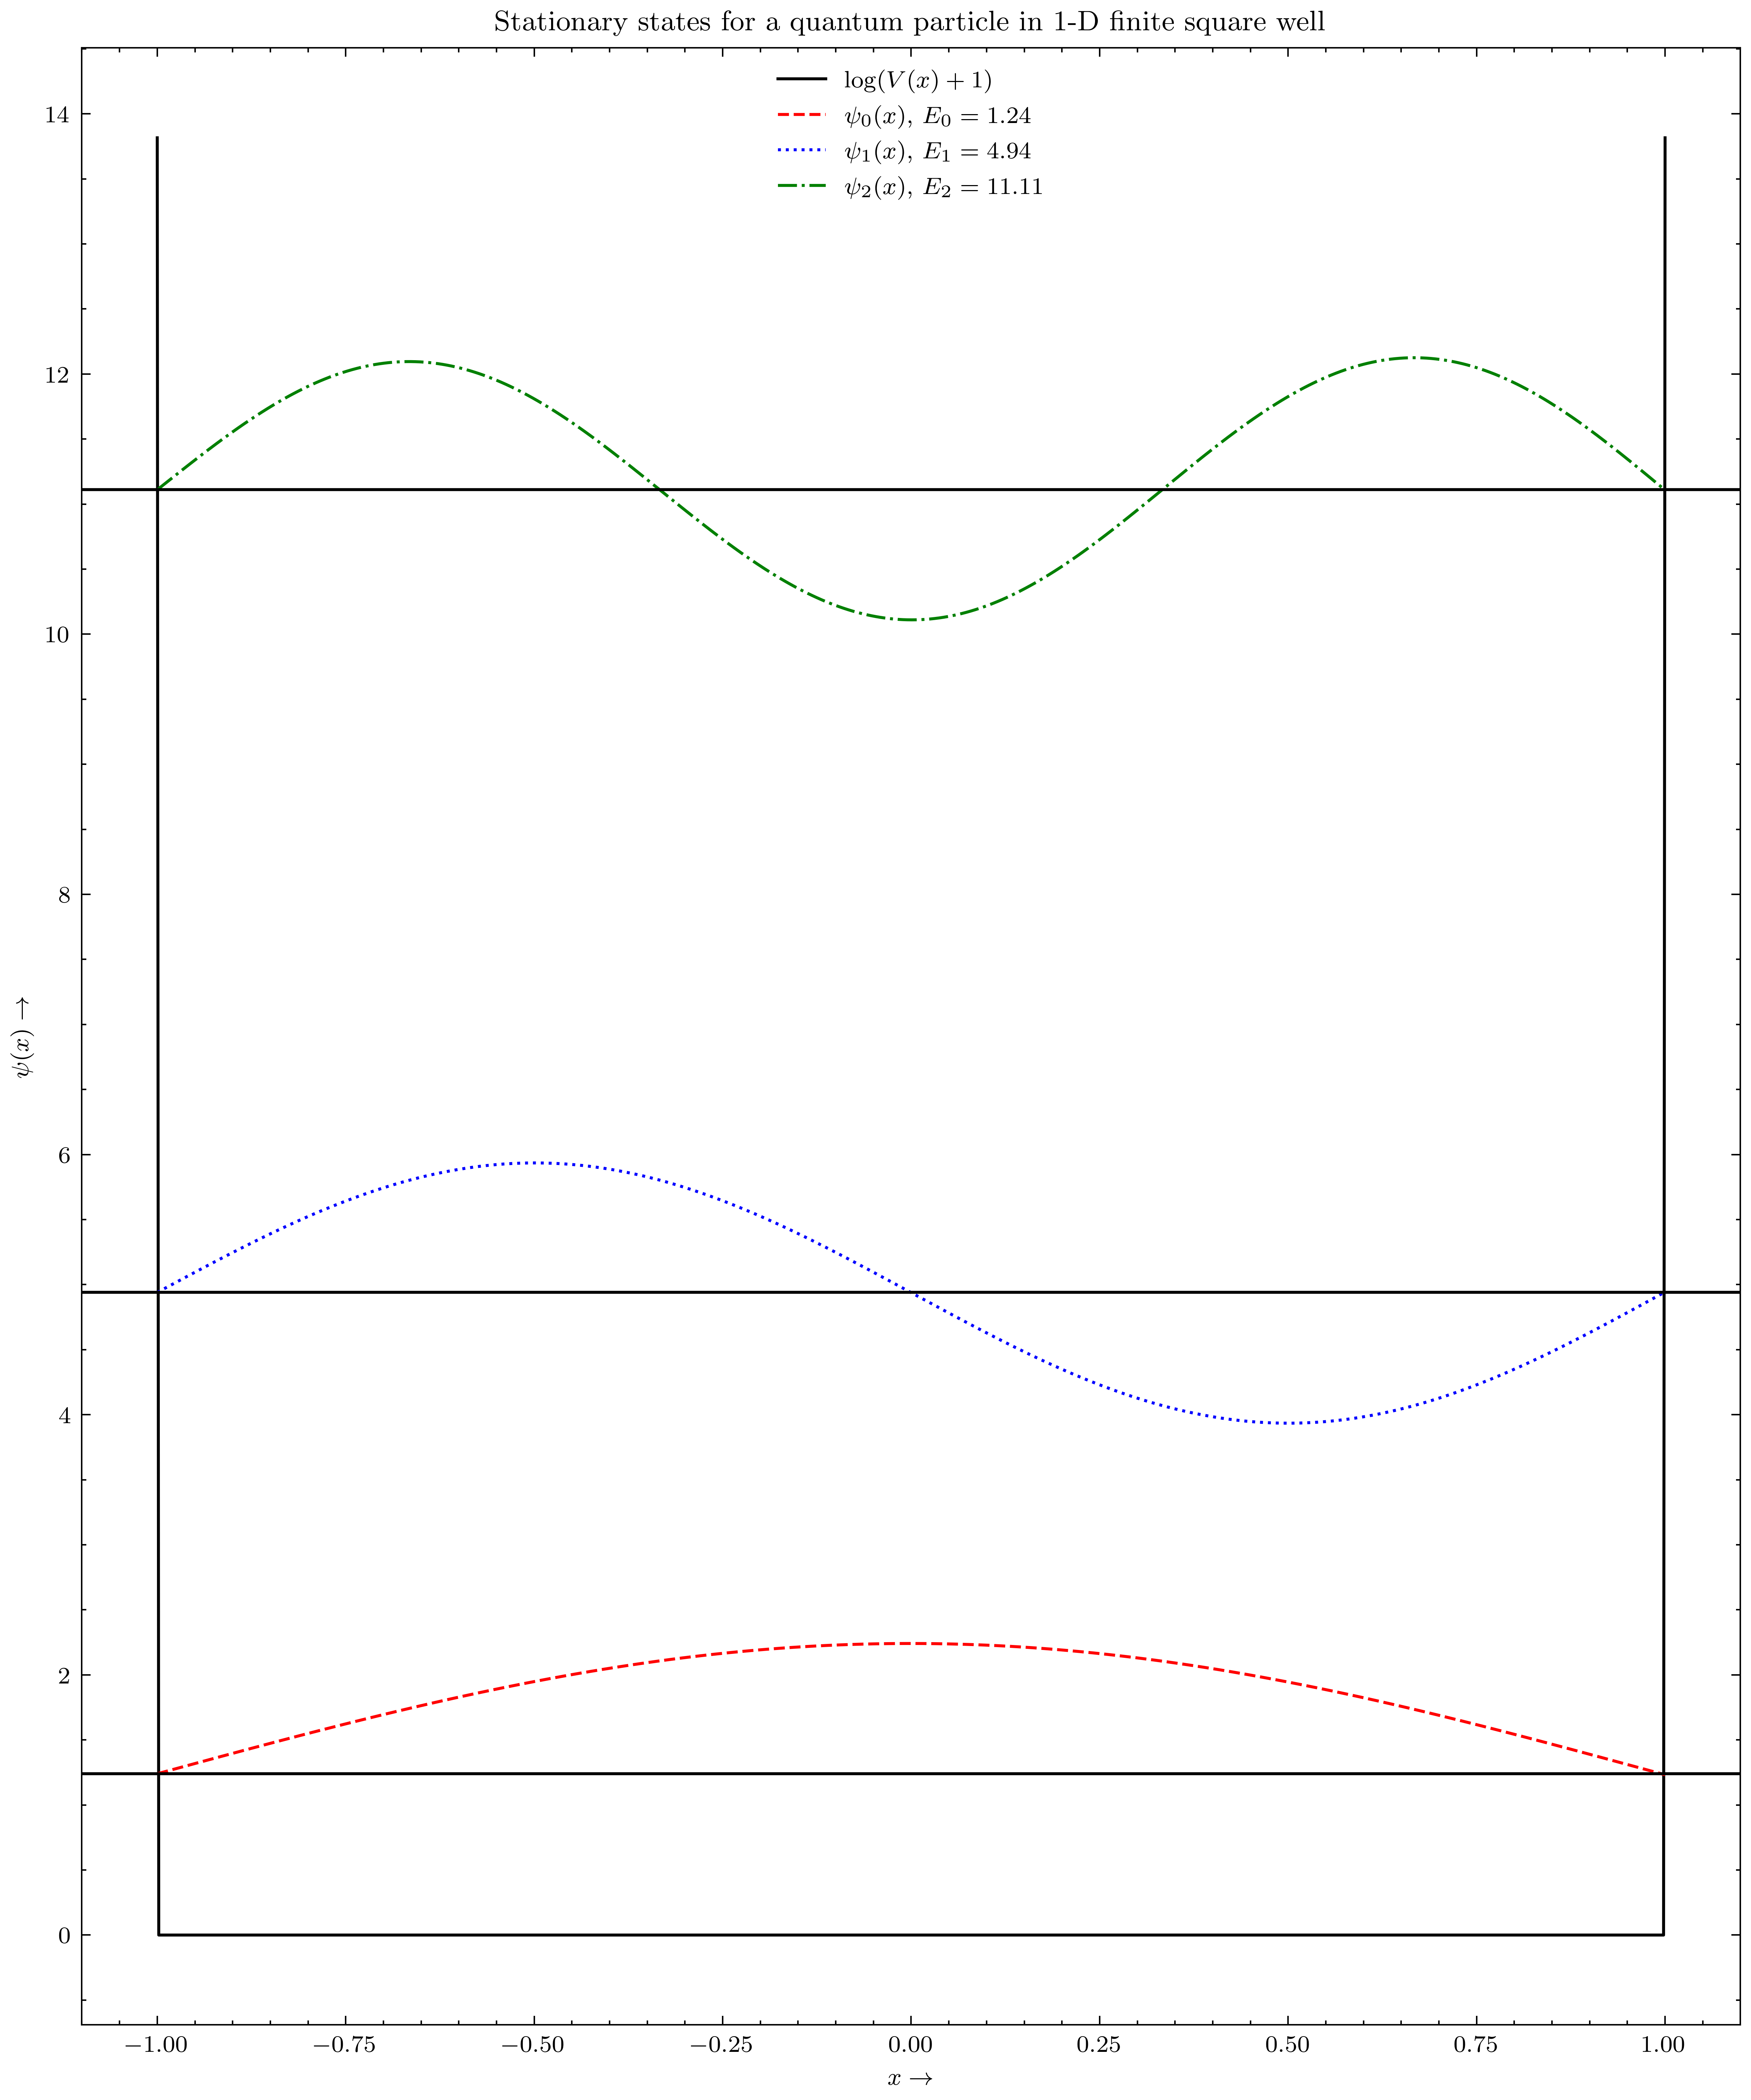

In [15]:
plt.plot(x, np.log(V(x) + 1), label="$\\log(V(x) + 1)$")

for i in range(E.size):
    plt.plot(x , E[i] + psi[i]/np.sqrt(integrate.simpson(psi[i]**2, x)), label=f"$\psi_{i}(x)$, $E_{i} = {round(E[i], 2)}$")
    plt.axhline(E[i])

plt.title("Stationary states for a quantum particle in 1-D finite square well")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$\psi(x) \\rightarrow$")
plt.legend()
plt.show()

### Finite square potential well

$$V(x)
=
\begin{cases}
0, & -a < x < a\\
V_0, & \text{otherwise}
\end{cases}
$$

In [10]:
a = 1
V_0 = 10

@np.vectorize
def V(x):
    if -a < x < a:
        return 0
    else:
        return V_0

xi, xf, yi, yf= -1.5, 1.5, 0, 0
Ei, Ef, Eh = 0, 8, 0.01

x, E, psi = solve_eig_eqn(sch_eqn(V), xi, xf, yi, yf, Ei, Ef, Eh)

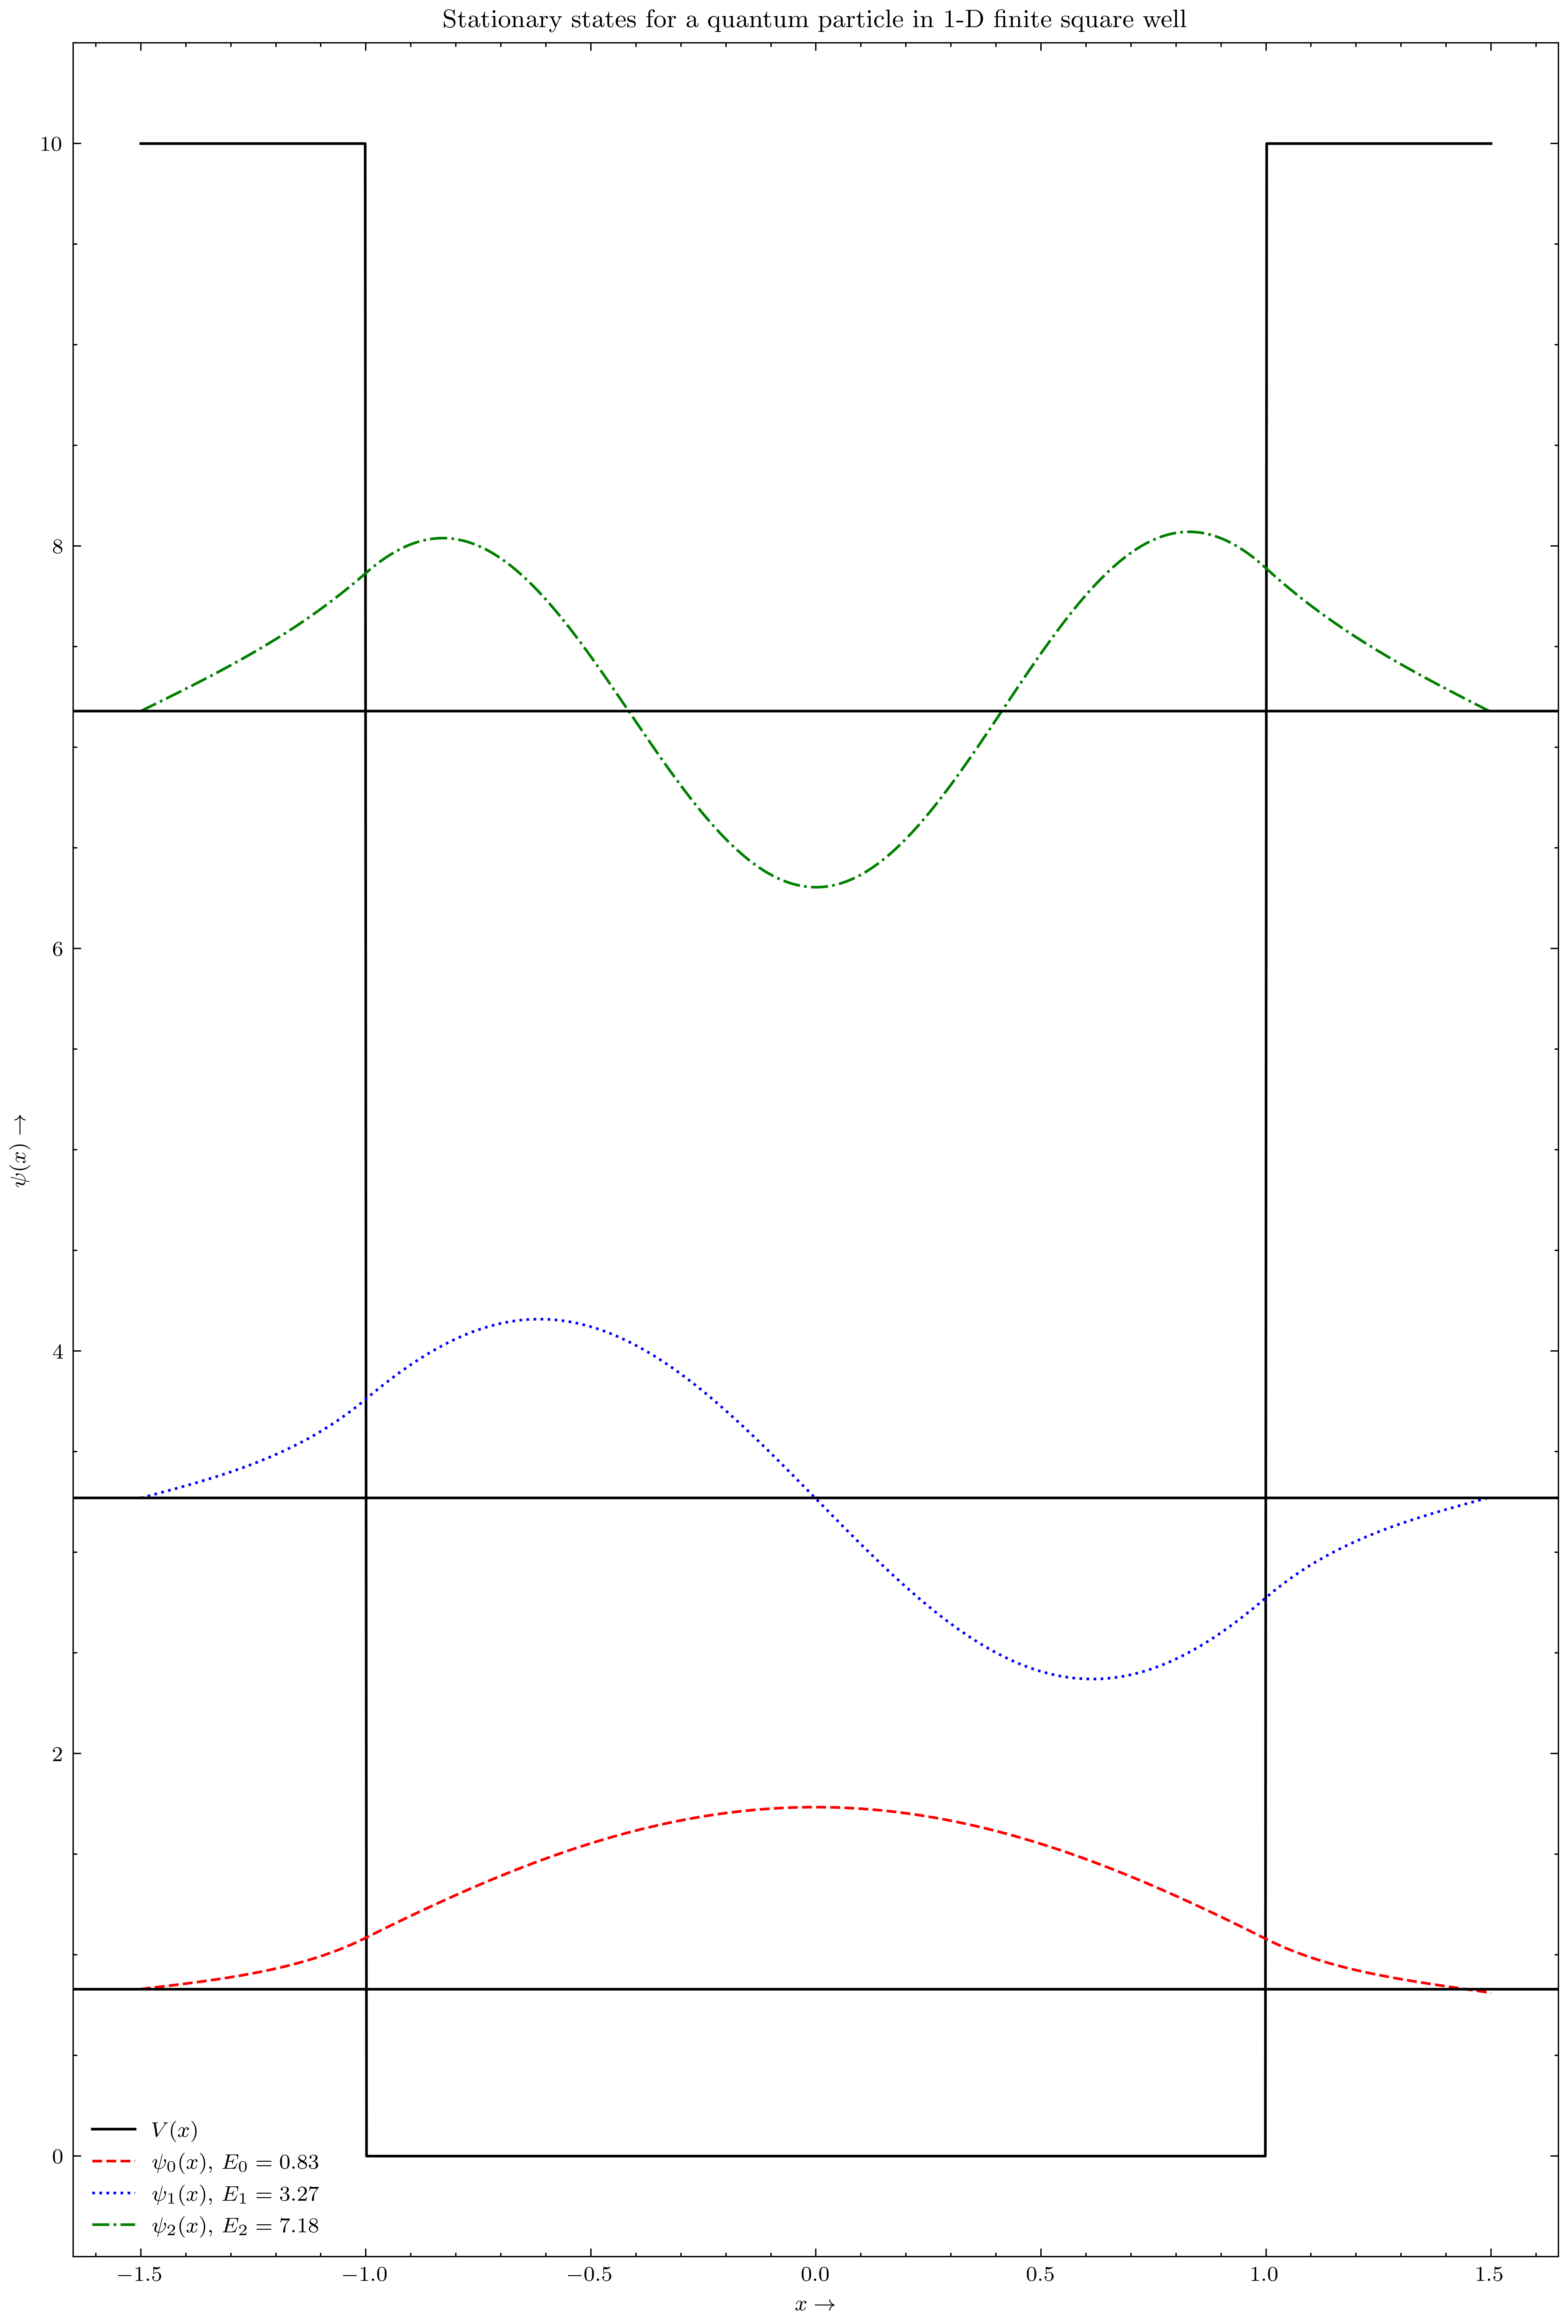

In [11]:
plt.plot(x, V(x), label="$V(x)$")

for i in range(E.size):
    plt.plot(x , E[i] + psi[i]/np.sqrt(integrate.simpson(psi[i]**2, x)), label=f"$\psi_{i}(x)$, $E_{i} = {round(E[i], 2)}$")
    plt.axhline(E[i])

plt.title("Stationary states for a quantum particle in 1-D finite square well")
plt.xlabel("$x \\rightarrow$")
plt.ylabel("$\psi(x) \\rightarrow$")
plt.legend()
plt.show()